In [3]:
#%% load some libraries and set a few global parameters
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.special import erfc, erfcinv
from numpy.polynomial.hermite import hermgauss
#import torch
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

from numba import jit

plt.rcParams['font.size'] = 15
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

N = 50 # number of input glomeruli
Ks = np.arange(2,21) #number of inputs per KC to consider
S = 14000 #total number of connections (K*M)
Ms = np.round(S/Ks, 0).astype(int) #number of KCs (S/K)
f = 0.1 #coding level

In [4]:
### define a bunch of functions that might be useful ###
@jit
def get_J_orig(K, N, M, rep):
  J = np.zeros((rep, N, M)) #weight matrix
  for r in range(rep): #for each repetition
      for i in range(M): #for each KC
          #randomly sample an input weight vector (this could probs be parallelized)
          J[r, np.random.choice(N, K, replace = False), i] = 1
  return J

@jit
def get_J_var(K, N, M, rep):
  p = 0.2
  J = np.zeros((rep, N, M)) #weight matrix
  for r in range(rep): #for each repetition
    for i in range(M)[::2]: #for each KC
        #randomly sample an input weight vector (this could probs be parallelized)
        if i == (M-1):
          J[r, np.random.choice(N, K, replace = False), i] = 1
        elif np.random.uniform() < p:
          J[r, np.random.choice(N, K+1, replace = False), i] = 1
          J[r, np.random.choice(N, K-1, replace = False), i+1] = 1
        else:
          J[r, np.random.choice(N, K, replace = False), i] = 1
          J[r, np.random.choice(N, K, replace = False), i+1] = 1
  return J

get_J = get_J_orig
get_J = get_J_var



@jit
def get_R(J, X, f):
  Y = X@J #compute input to KCs
  sigs = np.sqrt(np.sum(J**2, axis = 1, keepdims = True)) #std of y_i
  #compute threshold
  thresh = np.sqrt(2)*sigs*erfcinv(2*f)
  #pass through nonlinearity
  R = 0.5*np.sign(Y - thresh)+0.5
  #mean subtract to compute covariance
  R = R - np.mean(R, axis = 1, keepdims = True)
  return R

@jit
def get_dim(R):
  #compute dimensionality with traces of covariance matrices
  #consider using Hutchinson's trace estimator instead
  #compute covariance matrix

  C = R.transpose(0,2,1) @ R
  #C = (torch.Tensor(R.transpose(0,2,1)).to(device) @ torch.Tensor(R).to(device)).cpu().numpy()

  trs = np.trace(C, axis1=1, axis2=2)
  dim = trs**2/np.sum(C**2, axis = (1,2))
  return dim


In [5]:
T = 10000 #input datapoints to consider
rep = 2 #number of repetitions (samples from the weight matrix distribution)
dims = np.zeros((len(Ms), 2)) #array for storing results
tic = time.time() #count time

for iK in range(len(Ks)): #for each K
  K, M = Ks[iK], Ms[iK]
  X = np.random.normal(0, 1, (rep, (1000 if K == 1 else T), N)) #Gaussian inputs
  J = get_J(K, N, M, rep)
  for iinh in [0,1]:
    if iinh == 1: J = J - np.mean(J)
    R = get_R(J, X, f)
    dim = get_dim(R)
    #store result
    dims[iK, iinh] = np.mean(dim)

  #print progress
  print(K, dims[iK, :]/N, np.round(time.time() - tic, 3))

<ipython-input-4-51a5e2d0704e>:11: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_J_var" failed type inference due to: No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(range_state_int64, slice<a:b:c>)
 
There are 22 candidate implementations:
  - Of which 22 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(range_state_int64, slice<a:b:c>)':
   No match.

During: typing of intrinsic-call at <ipython-input-4-51a5e2d0704e> (16)
During: typing of static-get-item at <ipython-input-4-51a5e2d0704e> (16)

File "<ipython-input-4-51a5e2d0704e>", line 16:
def get_J_var(K, N, M, rep):
    <source elided>
  for r in range(rep): #for each repetition
    for i in range(M)[::2]: #for each KC
    ^

  @jit
<ipython-input-4-51a5e2d0704e>:11: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because 

2 [3.27690532 3.50199702] 14.087
3 [3.99782654 4.72874754] 20.459
4 [3.95276015 5.25953446] 24.557
5 [3.60997702 5.53103206] 27.637
6 [3.21524387 5.65294383] 29.981
7 [2.79590128 5.7187358 ] 32.041
8 [2.43690776 5.74830451] 33.771
9 [2.14635552 5.71619871] 35.411
10 [1.85185335 5.67269977] 36.776
11 [1.56118162 5.61994884] 37.996
12 [1.36272893 5.53950913] 39.087
13 [1.20269497 5.47611869] 40.195
14 [1.0382864  5.41670942] 41.062
15 [0.93194256 5.34491576] 41.898
16 [0.79162925 5.25954627] 42.699
17 [0.7127937  5.17531402] 43.407
18 [0.62543666 5.07946323] 44.09
19 [0.5594172  5.01403143] 44.745
20 [0.4935715  4.94071551] 45.346


[3 8]
[3.99782654 5.74830451]


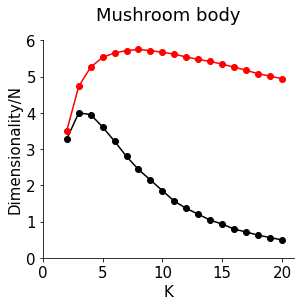

In [6]:
print(Ks[np.argmax(dims, axis = 0)])
print(np.amax(dims, axis = 0)/N)

plt.figure(figsize = (4.5,4))
plt.plot(Ks, dims[:, 0]/N, '-o', color = 'k')
plt.plot(Ks, dims[:, 1]/N, '-o', color = 'r')
plt.xlabel('K')
plt.ylabel('Dimensionality/N')
plt.ylim(0, np.amax(dims)/N*1.1)
plt.title('Mushroom body', pad = 20)
plt.xticks([0,5,10,15,20])
plt.xlim(0, 21)
plt.yticks(range(7))
plt.ylim(0, 6)
plt.show()